# Radiomics 2: Replicating the analysis carried out by Ahmed et al., (2020) 
# DOI: https://doi.org/10.1016/j.crad.2020.01.012

Analysis was already carried out to extract radiomic features from high and low groups for my own project. However, I wish to replicate the analysis carried out by Ahmed et al. in order to verify that the features that I extracted are legitimate.

Since my low group is the same as their low group, these nifti files are ready for analysis. However, Ahmed et al had 40/53 patients in their high group compared with myself having only 13/53 patients in my high group. 

Therefore I need to download the remaining patient imaging data from TCIA and convert their respective files to nifti format and then add them to my existing high nifti samples and then commence the analysis.

In [26]:
# Importing necessary libraries
import os
import shutil
import glob
import SimpleITK as sitk
from DicomRTTool.ReaderWriter import DicomReaderWriter
import subprocess
import pydicom
import radiomics
from radiomics import featureextractor
import logging
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu
import statsmodels.api as sm
import statsmodels.stats.multitest as multitest
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE
import scipy.stats as stats
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path

In [2]:
# Converting "high_ki67" DICOM files to Nifti use dcm2niix:
def convert_dicom_to_nifti(dicom_root_path, nifti_output_path):
    if not os.path.exists(nifti_output_path):
        os.makedirs(nifti_output_path)

    for root, dirs, files in os.walk(dicom_root_path):
        for dir_name in dirs:
            dicom_path = os.path.join(root, dir_name)
            sub_nifti_output_path = os.path.join(nifti_output_path, dir_name)
            if not os.path.exists(sub_nifti_output_path):
                os.makedirs(sub_nifti_output_path)

            # Using dcm2niix solely on regular imaging files
            command = f'dcm2niix -o "{sub_nifti_output_path}" "{dicom_path}"'
            try:
                subprocess.run(command, shell=True, check=True)
                print(f'Converted DICOM files in {dicom_path} to NIfTI format at {sub_nifti_output_path}.')
            except subprocess.CalledProcessError as e:
                print(f'Error converting {dicom_path} with dcm2niix: {e}')
                continue

# Paths to DICOM and NIfTI directories
base_path = '/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67'
high_dicom_path = os.path.join(base_path, 'Adrenal-ACC-Ki67-Seg')
high_nifti_output_path = os.path.join(base_path, 'high2_ki67_nifti')

# Convert High Group DICOM to NIfTI
convert_dicom_to_nifti(high_dicom_path, high_nifti_output_path)

Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 166 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_002/09-25-2001-NA-CT ABDOMEN-85015/300.000000-Segmentation-67488/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 56 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_002/Adrenal_Ki67_Seg_002_SURE_START_ABD_1_10_5_5_20010925093044_6 (512x512x56x1)
Convert 56 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_002/Adrenal_Ki67_Seg_002_NON_CON_ABD_1_10_5_5_20010925093044_3 (512x512x56x1)
Convert 53 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_002/Adrenal_Ki67_Seg_002_NON_CON_ABD_1_10_5_5_20010925093044_8 (512x512x53x1)


Error: Converted 165 of 166 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_002 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_002" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_002"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 221 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_003/10-14-2003-NA-CT ABDOMEN-08445/300.000000-Segmentation-73195/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 59 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_003/Adrenal_Ki67_Seg_003_6.6_ABD_PELVIS_WO_W_20031014112008_2 (

Error: Converted 220 of 221 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_003 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_003" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_003"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 207 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_004/06-28-2004-NA-CT ABDOMEN-75328/300.000000-Segmentation-36430/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 88 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_004/Adrenal_Ki67_Seg_004_ABDPELVIS_ROUTINE_20040628085530_6 (51

Error: Converted 206 of 207 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_004 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_004" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_004"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 227 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_007/03-12-2005-NA-CT ABDOMEN-34185/300.000000-Segmentation-74582/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 117 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_007/Adrenal_Ki67_Seg_007_6.9_ABDOMEN_WITH_CONTRAST_20050312105

Error: Converted 226 of 227 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_007 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_007" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_007"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 274 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_008/05-15-2005-NA-CT ABDOMEN-07400/300.000000-Segmentation-75094/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 217 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_008/Adrenal_Ki67_Seg_008_6.2_Abdomen_Pelvis_20050515111444_103

Error: Converted 273 of 274 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_008 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_008" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_008"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 2184 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_010/09-20-2005-NA-CT ABDOMEN-41278/300.000000-Segmentation-22004/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 721 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_010/Adrenal_Ki67_Seg_010_MULTIPHASE_ABD_TIMED_Abdomen_2005092

Error: Converted 2183 of 2184 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_010 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_010" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_010"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 97 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_011/11-29-2005-NA-CT ABDPELVIS-W-03738/300.000000-Segmentation-36353/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 96 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_011/Adrenal_Ki67_Seg_011_6.2_Abdomen_Pelvis_WITH_20051129101

Error: Converted 96 of 97 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_011 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_011" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_011"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 155 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_014/11-04-2006-NA-CT ABDOMEN-67659/300.000000-Segmentation-42695/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 37 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_014/Adrenal_Ki67_Seg_014_ABDOMEN_ONLY_WO_20061104105641_9 (512x

Error: Converted 154 of 155 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_014 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_014" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_014"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 486 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_019/12-22-2007-NA-ABD ADRENAL SURG -54029/300.000000-Segmentation-51850/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel


Convert 203 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_019/Adrenal_Ki67_Seg_019_No_series_description_20071222203417_13 (512x512x203x1)
Convert 73 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_019/Adrenal_Ki67_Seg_019_8.3_@_ADRENAL_A_P_DFOV_40CM_AND_BELOW_@_20071222203417_18 (512x512x73x1)
Convert 209 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_019/Adrenal_Ki67_Seg_019_8.3_@_ADRENAL_A_P_DFOV_40CM_AND_BELOW_@_20071222203417_5 (512x512x209x1)


Error: Converted 485 of 486 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_019 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_019" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_019"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 411 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_020/02-05-2008-NA-CT ABDOMEN-31602/300.000000-Segmentation-25281/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 205 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_020/Adrenal_Ki67_Seg_020_6.1_Abdomen_Pelvis_20080205150222_5 (

Error: Converted 410 of 411 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_020 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_020" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_020"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 101 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_022/03-01-2008-NA-CT ABDOMEN W  PELVIS W CONT-55485/300.000000-Segmentation-20675/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 100 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_022/Adrenal_Ki67_Seg_022_6.1_ABD_PEL_WITH_CON

Error: Converted 100 of 101 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_022 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_022" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_022"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 55 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_023/05-05-2008-NA-CT ABDOMEN-73150/300.000000-Segmentation-11429/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 54 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_023/Adrenal_Ki67_Seg_023_6.2_ABD_PEL_W_CONTRAST_20080505014157_2

Error: Converted 54 of 55 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_023 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_023" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_023"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 390 DICOM file(s)


Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_027/11-25-2008-NA-CAPADRENAL-99577/300.000000-Segmentation-87754/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 99 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_027/Adrenal_Ki67_Seg_027_8.6_@_ADRENAL_C_A_P_DFOV_42CM_AND_ABOVE_@_20081125100603_5 (512x512x99x1)
Convert 105 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_027/Adrenal_Ki67_Seg_027_8.6_@_ADRENAL_C_A_P_DFOV_42CM_AND_ABOVE_@_20081125100603_24 (512x512x105x1)
Convert 185 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_027/Adrenal_Ki67_Seg_027_No_series_description_20081125100603_14 (512x512x185x1)


Error: Converted 389 of 390 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_027 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_027" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_027"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 514 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_030/02-17-2009-NA-ABD ADRENAL-02292/300.000000-Segmentation-02306/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 149 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_030/Adrenal_Ki67_Seg_030_No_series_description_20090217191700

Convert 153 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_030/Adrenal_Ki67_Seg_030_8.3_@_ADRENAL_A_P_DFOV_40CM_AND_BELOW_@_20090217191700_20 (512x512x153x1)
Convert 211 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_030/Adrenal_Ki67_Seg_030_8.3_@_ADRENAL_A_P_DFOV_40CM_AND_BELOW_@_20090217191700_7 (512x512x211x1)


Error: Converted 513 of 514 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_030 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_030" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_030"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 264 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_032/05-23-2009-NA-CT Chest-61640/300.000000-Segmentation-21026/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 154 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_032/Adrenal_Ki67_Seg_032_TRAUMA_HEAD_C_SPINE_20090523184119_3 (5

Error: Converted 263 of 264 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_032 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_032" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_032"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 181 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_037/02-09-2009-NA-CT Abdomen  Pelvis-63206/300.000000-Segmentation-82171/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 90 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_037/Adrenal_Ki67_Seg_037_6.2_ABD_PEL_W_20090209163118_4

Error: Converted 180 of 181 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_037 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_037" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_037"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 286 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_040/11-16-2010-NA-CT CHEST ABDOMEN PELVIS-87876/300.000000-Segmentation-03536/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 78 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_040/Adrenal_Ki67_Seg_040_6.1_CT_ABDOMEN_W_CONTRAST

Error: Converted 285 of 286 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_040 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_040" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_040"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 96 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_041/12-18-2010-NA-CT ABDOMEN AND PELVIS-60177/300.000000-Segmentation-85513/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 95 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_041/Adrenal_Ki67_Seg_041_6.1_ROUTINE_ABD_PELVIS_W_CON

Error: Converted 95 of 96 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_041 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_041" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_041"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 874 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_042/06-19-2011-NA-CT CHEST ABDOMEN PELVIS W WO CONTRAST-89627/300.000000-Segmentation-99247/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel


Convert 243 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_042/Adrenal_Ki67_Seg_042_7.9_ADRENAL_CAP_42_DFOV_AND_ABOVE_@_20110619130512_4 (512x512x243x1)
Convert 387 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_042/Adrenal_Ki67_Seg_042_7.9_ADRENAL_CAP_42_DFOV_AND_ABOVE_@_20110619130512_20 (512x512x387x1)
Convert 243 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_042/Adrenal_Ki67_Seg_042_No_series_description_20110619130512_10 (512x512x243x1)


Error: Converted 873 of 874 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_042 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_042" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_042"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 185 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_045/06-21-2011-NA-CT CHEST ABDOMEN PELVIS-68532/300.000000-Segmentation-11611/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 126 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_045/Adrenal_Ki67_Seg_045_CHEST_ABDOMEN_Thorax_201

Error: Converted 184 of 185 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_045 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_045" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_045"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 724 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_046/10-08-2011-NA-CT ABDOMEN-96039/300.000000-Segmentation-68934/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel


Convert 181 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_046/Adrenal_Ki67_Seg_046_No_series_description_20111008130959_4 (512x512x181x1)
Convert 271 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_046/Adrenal_Ki67_Seg_046_ABD_ADRENAL_Abdomen_20111008130959_7 (512x512x271x1)
Convert 271 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_046/Adrenal_Ki67_Seg_046_ABD_ADRENAL_Abdomen_20111008130959_3 (512x512x271x1)


Error: Converted 723 of 724 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_046 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_046" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_046"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 148 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_047/03-03-2012-NA-CT ABDOMEN AND PELVIS-04015/300.000000-Segmentation-06609/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 147 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_047/Adrenal_Ki67_Seg_047_ABD_PEL_W_LESS_90KG_201203

Error: Converted 147 of 148 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_047 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_047" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_047"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 349 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_049/11-21-2011-NA-CT CHEST ABDOMEN PELVIS-48409/300.000000-Segmentation-58936/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 72 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_049/Adrenal_Ki67_Seg_049_CAP_WO_20111121150751_8 (

Error: Converted 348 of 349 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_049 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_049" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_049"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 169 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_050/12-11-2011-NA-CT ABDOMEN AND PELVIS-19066/300.000000-Segmentation-70908/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 168 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_050/Adrenal_Ki67_Seg_050_ABDOMEN_PELVIS_W_Abdomen_2

Error: Converted 168 of 169 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_050 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_050" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_050"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 122 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_051/02-20-2012-NA-CT ABDOMEN AND PELVIS-45488/300.000000-Segmentation-43028/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 121 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_051/Adrenal_Ki67_Seg_051_2_PHASE_PANCREAS_Abdomen_2

Error: Converted 121 of 122 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_051 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_051" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_051"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 295 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_053/06-08-2013-NA-SpecialsADRENALABDWOW Adult-88561/300.000000-Segmentation-13639/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 92 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_053/Adrenal_Ki67_Seg_053_ADRENAL_ABD_WO_W_2013

Error: Converted 294 of 295 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_053 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_053" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_053"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 182 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_025/09-13-2008-NA-CT ABDOMEN PELVIS W WO CONTRAST-23228/300.000000-Segmentation-99762/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 90 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_025/Adrenal_Ki67_Seg_025_6.1_ROUTINE_Abd_P

Error: Converted 181 of 182 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_025 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_025" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_025"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 887 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_012/08-05-2006-NA-ABDPELVIS ANGIOVENO-49507/300.000000-Segmentation-00566/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 117 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_012/Adrenal_Ki67_Seg_012_7.18_@_ANGIOGRAM_VENOGRAM_@_

Error: Converted 886 of 887 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_012 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_012" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_012"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 281 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_013/09-11-2006-NA-AbdomenABDWOW Adult-52415/300.000000-Segmentation-11514/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 96 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_013/Adrenal_Ki67_Seg_013_ABD_WO_W_20060911130257_4 (51

Error: Converted 280 of 281 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_013 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_013" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_013"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 434 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_016/10-17-2006-NA-CT ABDOMEN-PELVIS WITH CONTRAST-92305/300.000000-Segmentation-46674/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 433 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_016/Adrenal_Ki67_Seg_016_Abdomen_Avg._Abd

Error: Converted 433 of 434 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_016 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_016" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_016"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 332 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_017/12-19-2007-NA-AABD ADRENAL-39139/300.000000-Segmentation-96192/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 115 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_017/Adrenal_Ki67_Seg_017_7.7_@_ADRENAL_SMALL_MASS_-_ABDOMEN_

Error: Converted 331 of 332 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_017 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_017" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_017"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 139 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_021/03-31-2008-NA-CT ABDOMEN W WO CONTRAST-40944/300.000000-Segmentation-80028/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 33 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_021/Adrenal_Ki67_Seg_021_ADRENAL_MASS_Abdomen_200

Error: Converted 138 of 139 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_021 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_021" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_021"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 270 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_024/08-11-2008-NA-CT ABDOMEN-80922/300.000000-Segmentation-97769/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 91 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_024/Adrenal_Ki67_Seg_024_ABDOMEN_PELVIS_WO_W_20080811142006_4 (

Error: Converted 269 of 270 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_024 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_024" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_024"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 446 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_028/09-21-2008-NA-UROGRAM-35288/300.000000-Segmentation-69303/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 286 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_028/Adrenal_Ki67_Seg_028_6.9_UROGRAM_20080921141905_5 (512x512x28

Error: Converted 445 of 446 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_028 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_028" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_028"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 274 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_033/09-08-2009-NA-CT Abdomen-90660/300.000000-Segmentation-91896/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 94 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_033/Adrenal_Ki67_Seg_033_6.6_CHEST_ABD_PELVIS_DUAL_ENERGY_THREE

Error: Converted 273 of 274 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_033 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_033" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_033"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 286 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_035/11-17-2009-NA-CT Abdomen-84810/300.000000-Segmentation-77548/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 95 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_035/Adrenal_Ki67_Seg_035_04MultiPhaseAdrenals_20091117161420_2 

Error: Converted 285 of 286 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_035 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_035" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_035"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 220 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_038/02-23-2010-NA-CT ABDOMEN PELVIS W WO CONTRAST-02235/300.000000-Segmentation-22094/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 89 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_038/Adrenal_Ki67_Seg_038_6.1_Abdomen_&_Pel

Error: Converted 219 of 220 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_038 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_038" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_038"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 276 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_039/02-08-2010-NA-CT Abdomen-18373/300.000000-Segmentation-78069/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 79 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_039/Adrenal_Ki67_Seg_039_ADI_ADRENAL_20100208180635_9 (512x512x

Error: Converted 275 of 276 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_039 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_039" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_039"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 153 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_044/10-25-2009-NA-CT ABDOMEN-76702/300.000000-Segmentation-61494/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 41 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_044/Adrenal_Ki67_Seg_044_6.8_ABD_PELVIS_REDUCED_TECHNIQUE_OVER_

Error: Converted 152 of 153 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_044 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_044" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_044"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 732 DICOM file(s)


Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_052/05-14-2013-NA-CT CHEST ABDOMEN PELVIS W WO CONTRAST-12147/300.000000-Segmentation-48086/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 325 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_052/Adrenal_Ki67_Seg_052_7.7_ADRENAL_CAP_42_DFOV_AND_ABOVE_@_20130514074620_20 (512x512x325x1)
Convert 205 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_052/Adrenal_Ki67_Seg_052_No_series_description_20130514074620_10 (512x512x205x1)
Convert 201 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_052/Adrenal_Ki67_Seg_052_7.7_ADRENAL_CAP_42_DFOV_AND_ABOVE_@_20130514074620_302 (512x512x201x1)


Error: Converted 731 of 732 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_052 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_052" "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_052"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 166 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_002/09-25-2001-NA-CT ABDOMEN-85015/300.000000-Segmentation-67488/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 56 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/09-25-2001-NA-CT ABDOMEN-85015/09-25-2001-NA-CT_ABDOMEN-85015_SURE_START_ABD_1_1

KeyboardInterrupt: 

Once again, the code overlooped so just interrupt kernel after obtaining all required samples.

In [3]:
# Converting the segmentation files to nifti format
def convert_segmentation_files(dicom_root_path, nifti_output_path):
    if not os.path.exists(nifti_output_path):
        os.makedirs(nifti_output_path)

    for root, dirs, files in os.walk(dicom_root_path):
        for dir_name in dirs:
            dicom_path = os.path.join(root, dir_name)
            sub_nifti_output_path = os.path.join(nifti_output_path, dir_name)
            if not os.path.exists(sub_nifti_output_path):
                os.makedirs(sub_nifti_output_path)

            for file_name in os.listdir(dicom_path):
                file_path = os.path.join(dicom_path, file_name)
                try:
                    ds = pydicom.dcmread(file_path)
                    if hasattr(ds, 'Modality') and ds.Modality == 'SEG':
                        seg_sitk_image = sitk.ReadImage(file_path)
                        seg_nifti_file = os.path.join(sub_nifti_output_path, f"{dir_name}_{file_name.replace('.dcm', '.nii.gz')}")
                        sitk.WriteImage(seg_sitk_image, seg_nifti_file)
                        print(f'Converted segmentation DICOM {file_path} to NIfTI format at {seg_nifti_file}.')
                except Exception as e:
                    print(f'Could not read file {file_path}: {e}')

# Paths to DICOM and NIfTI directories
high_dicom_path = os.path.join(base_path, 'Adrenal-ACC-Ki67-Seg')
high_nifti_output_path = os.path.join(base_path, 'high2_ki67_nifti')

# Convert High Group Segmentation Files
convert_segmentation_files(high_dicom_path, high_nifti_output_path)

Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_002/09-25-2001-NA-CT ABDOMEN-85015: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_002/09-25-2001-NA-CT ABDOMEN-85015'
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_003/10-14-2003-NA-CT ABDOMEN-08445: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_003/10-14-2003-NA-CT ABDOMEN-08445'
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_004/06-28-2004-NA-CT ABDOMEN-75328: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_004/06-28-2004-N

Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_053/06-08-2013-NA-SpecialsADRENALABDWOW Adult-88561: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_053/06-08-2013-NA-SpecialsADRENALABDWOW Adult-88561'
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_025/09-13-2008-NA-CT ABDOMEN PELVIS W WO CONTRAST-23228: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_025/09-13-2008-NA-CT ABDOMEN PELVIS W WO CONTRAST-23228'
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_012/08-05-2006-NA-ABDPELVIS ANGIOVENO-49507: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tc

Converted segmentation DICOM /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_003/10-14-2003-NA-CT ABDOMEN-08445/300.000000-Segmentation-73195/1-1.dcm to NIfTI format at /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/300.000000-Segmentation-73195/300.000000-Segmentation-73195_1-1.nii.gz.
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_004/06-28-2004-NA-CT ABDOMEN-75328/4.000000-Non-Contrast  3.0  B31f-45272: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_004/06-28-2004-NA-CT ABDOMEN-75328/4.000000-Non-Contrast  3.0  B31f-45272'
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_004/06-28-2004-NA-CT ABDOMEN-75328/300.000000-Segmentation-3

Converted segmentation DICOM /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_011/11-29-2005-NA-CT ABDPELVIS-W-03738/300.000000-Segmentation-36353/1-1.dcm to NIfTI format at /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/300.000000-Segmentation-36353/300.000000-Segmentation-36353_1-1.nii.gz.
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_014/11-04-2006-NA-CT ABDOMEN-67659/3.000000-AbdOnly  5.0  B31f-95100: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_014/11-04-2006-NA-CT ABDOMEN-67659/3.000000-AbdOnly  5.0  B31f-95100'
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_014/11-04-2006-NA-CT ABDOMEN-67659/300.000000-Segmentation-42695: 

Converted segmentation DICOM /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_027/11-25-2008-NA-CAPADRENAL-99577/300.000000-Segmentation-87754/1-1.dcm to NIfTI format at /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/300.000000-Segmentation-87754/300.000000-Segmentation-87754_1-1.nii.gz.
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_030/02-17-2009-NA-ABD ADRENAL-38587/20.000000-15MIN DELAY  ST NI 21 A40-65546: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_030/02-17-2009-NA-ABD ADRENAL-38587/20.000000-15MIN DELAY  ST NI 21 A40-65546'
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_030/02-17-2009-NA-ABD ADRENAL-38587/7.000000-PRE LIV

Converted segmentation DICOM /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_041/12-18-2010-NA-CT ABDOMEN AND PELVIS-60177/300.000000-Segmentation-85513/1-1.dcm to NIfTI format at /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/300.000000-Segmentation-85513/300.000000-Segmentation-85513_1-1.nii.gz.
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_042/06-19-2011-NA-CT CHEST ABDOMEN PELVIS W WO CONTRAST-89627/300.000000-Segmentation-99247: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_042/06-19-2011-NA-CT CHEST ABDOMEN PELVIS W WO CONTRAST-89627/300.000000-Segmentation-99247'
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_042/06-19-201

Converted segmentation DICOM /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_049/11-21-2011-NA-CT CHEST ABDOMEN PELVIS-48409/300.000000-Segmentation-58936/1-1.dcm to NIfTI format at /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/300.000000-Segmentation-58936/300.000000-Segmentation-58936_1-1.nii.gz.
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_050/12-11-2011-NA-CT ABDOMEN AND PELVIS-19066/300.000000-Segmentation-70908: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_050/12-11-2011-NA-CT ABDOMEN AND PELVIS-19066/300.000000-Segmentation-70908'
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_050/12-11-2011-NA-CT ABDOMEN AND PELVIS-190

Converted segmentation DICOM /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_013/09-11-2006-NA-AbdomenABDWOW Adult-52415/300.000000-Segmentation-11514/1-1.dcm to NIfTI format at /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/300.000000-Segmentation-11514/300.000000-Segmentation-11514_1-1.nii.gz.
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_016/10-17-2006-NA-CT ABDOMEN-PELVIS WITH CONTRAST-92305/2770.000000-ABDPL-58042: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_016/10-17-2006-NA-CT ABDOMEN-PELVIS WITH CONTRAST-92305/2770.000000-ABDPL-58042'
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_016/10-17-2006-NA-CT ABDOMEN-PELVIS WIT

Converted segmentation DICOM /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_028/09-21-2008-NA-UROGRAM-35288/300.000000-Segmentation-69303/1-1.dcm to NIfTI format at /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/300.000000-Segmentation-69303/300.000000-Segmentation-69303_1-1.nii.gz.
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_033/09-08-2009-NA-CT Abdomen-90660/7.000000-CAP AX VENOUS-40885: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_033/09-08-2009-NA-CT Abdomen-90660/7.000000-CAP AX VENOUS-40885'
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_033/09-08-2009-NA-CT Abdomen-90660/2.000000-ABD AX WO CON-57474: [Errno 21] Is a di

Converted segmentation DICOM /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_044/10-25-2009-NA-CT ABDOMEN-76702/300.000000-Segmentation-61494/1-1.dcm to NIfTI format at /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/300.000000-Segmentation-61494/300.000000-Segmentation-61494_1-1.nii.gz.
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_052/05-14-2013-NA-CT CHEST ABDOMEN PELVIS W WO CONTRAST-50762/20.000000-ABD PEL AX 1.25 DEL 15-01130: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_052/05-14-2013-NA-CT CHEST ABDOMEN PELVIS W WO CONTRAST-50762/20.000000-ABD PEL AX 1.25 DEL 15-01130'
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_052/05

This code runs all samples and does not overloop. However, Delete unwanted excess folders created during the process and match each segmentation file to its associated sample file. Once all segmentation files have been matched with their respective folder, I need to move all the gzipped.nii segmentation files up a single directory so that they are in the same directory as the imaging files. I can do this through the following code:

In [6]:
base_path = '/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti'

# Iterate through each subdirectory in the base path
for subdir in os.listdir(base_path):
    subdir_path = os.path.join(base_path, subdir)
    
    if os.path.isdir(subdir_path):
        # Find the folder that starts with "300.000000"
        for folder in os.listdir(subdir_path):
            if folder.startswith("300.000000"):
                folder_path = os.path.join(subdir_path, folder)
                
                # Find the gzipped NIfTI file
                for file in os.listdir(folder_path):
                    if file.endswith(".nii.gz"):
                        file_path = os.path.join(folder_path, file)
                        destination_path = os.path.join(subdir_path, file)
                        
                        # Move the gzipped NIfTI file up one directory
                        shutil.move(file_path, destination_path)
                        print(f'Moved {file_path} to {destination_path}')

Moved /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_002/300.000000-Segmentation-67488/300.000000-Segmentation-67488_1-1.nii.gz to /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_002/300.000000-Segmentation-67488_1-1.nii.gz
Moved /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_003/300.000000-Segmentation-73195/300.000000-Segmentation-73195_1-1.nii.gz to /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_003/300.000000-Segmentation-73195_1-1.nii.gz
Moved /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_004/300.000000-Segmentation-36430/300.000000-Segmentation-36430_1-1.nii.gz to /media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti/Adrenal_Ki67_Seg_004/300.000000-Segment

After matching each segmentation file with its associated sample and removing unwanted folders, we can proceed with the extraction of radiomic features from each group of samples.

To do this we need to create a Params.yaml File with our intended parameters for PyRadiomics to run, and load it in. The Params file was taken from the PyRadiomics Github page and its parameters are specific for CT image analysis. This is the same Params.yaml file that I used for the other analysis of my own subcohorts.

We also need to find which imaging file is matched to the segmentation file in each sample and then add the image and mask file paths to a csv for pyradiomics batch processing feature extraction. This can be done by analysing each sample using 3DSlicer.

In [7]:
# Creating CSV file to use for PyRadiomics Batch

# Base paths
base_path_high = "/media/evannaughton/STORE N GO/project/tcia_data/median_ki67/high2_ki67/high2_ki67_nifti"
base_path_low = "/media/evannaughton/STORE N GO/project/tcia_data/low_ki67_nifti"

# List of filenames for high group 
high_images = [
    'Adrenal_Ki67_Seg_002/Adrenal_Ki67_Seg_002_SURE_START_ABD_1_10_5_5_20010925093044_6.nii',
    'Adrenal_Ki67_Seg_003/Adrenal_Ki67_Seg_003_6.6_ABD_PELVIS_WO_W_20031014112008_3.nii',
    'Adrenal_Ki67_Seg_004/Adrenal_Ki67_Seg_004_ABDPELVIS_ROUTINE_20040628085530_6.nii',
    'Adrenal_Ki67_Seg_007/Adrenal_Ki67_Seg_007_6.9_ABDOMEN_WITH_CONTRAST_20050312105900_2.nii',
    'Adrenal_Ki67_Seg_008/Adrenal_Ki67_Seg_008_6.2_Abdomen_Pelvis_20050515111444_103.nii',
    'Adrenal_Ki67_Seg_010/Adrenal_Ki67_Seg_010_MULTIPHASE_ABD_TIMED_Abdomen_20050920113032_10.nii',
    'Adrenal_Ki67_Seg_011/Adrenal_Ki67_Seg_011_6.2_Abdomen_Pelvis_WITH_20051129101902_2.nii',
    'Adrenal_Ki67_Seg_012/Adrenal_Ki67_Seg_012_7.18_@_ANGIOGRAM_VENOGRAM_@_20060805203016_5.nii',
    'Adrenal_Ki67_Seg_013/Adrenal_Ki67_Seg_013_ABD_WO_W_20060911130257_3.nii',
    'Adrenal_Ki67_Seg_014/Adrenal_Ki67_Seg_014_ABDOMEN_ONLY_WO_20061104105641_3.nii',
    'Adrenal_Ki67_Seg_016/Adrenal_Ki67_Seg_016_Abdomen_Avg._Abdomen_Hx_20061017113555_2770.nii',
    'Adrenal_Ki67_Seg_017/Adrenal_Ki67_Seg_017_7.7_@_ADRENAL_SMALL_MASS_-_ABDOMEN_-_42-46_DFOV_20071219132020_5.nii',
    'Adrenal_Ki67_Seg_019/Adrenal_Ki67_Seg_019_No_series_description_20071222203417_13.nii',
    'Adrenal_Ki67_Seg_020/Adrenal_Ki67_Seg_020_6.1_Abdomen_Pelvis_20080205150222_5.nii',
    'Adrenal_Ki67_Seg_021/Adrenal_Ki67_Seg_021_ADRENAL_MASS_Abdomen_20080331104143_3.nii',
    'Adrenal_Ki67_Seg_022/Adrenal_Ki67_Seg_022_6.1_ABD_PEL_WITH_CONTRAST_TIMED_LANDMARK_2_ABOVE_DIAPHRAGM_20080301092311_2.nii',
    'Adrenal_Ki67_Seg_023/Adrenal_Ki67_Seg_023_6.2_ABD_PEL_W_CONTRAST_20080505014157_2.nii',
    'Adrenal_Ki67_Seg_024/Adrenal_Ki67_Seg_024_ABDOMEN_PELVIS_WO_W_20080811142006_4.nii',
    'Adrenal_Ki67_Seg_025/Adrenal_Ki67_Seg_025_6.1_ROUTINE_Abd_Pelvis_20080913121500_103.nii',
    'Adrenal_Ki67_Seg_027/Adrenal_Ki67_Seg_027_No_series_description_20081125100603_14.nii',
    'Adrenal_Ki67_Seg_028/Adrenal_Ki67_Seg_028_6.9_UROGRAM_20080921141905_3.nii',
    'Adrenal_Ki67_Seg_030/Adrenal_Ki67_Seg_030_No_series_description_20090217191700_14.nii',
    'Adrenal_Ki67_Seg_032/Adrenal_Ki67_Seg_032_TRAUMA_HEAD_C_SPINE_20090523184119_3.nii',
    'Adrenal_Ki67_Seg_033/Adrenal_Ki67_Seg_033_6.6_CHEST_ABD_PELVIS_DUAL_ENERGY_THREE_PHASE_LIVER_20090908113425_7.nii',
    'Adrenal_Ki67_Seg_035/Adrenal_Ki67_Seg_035_04MultiPhaseAdrenals_20091117161420_7.nii',
    'Adrenal_Ki67_Seg_037/Adrenal_Ki67_Seg_037_6.2_ABD_PEL_W_20090209163118_2.nii',
    'Adrenal_Ki67_Seg_038/Adrenal_Ki67_Seg_038_6.1_Abdomen_&_Pelvis_20100223133437_3.nii',
    'Adrenal_Ki67_Seg_039/Adrenal_Ki67_Seg_039_ADI_ADRENAL_20100208180635_5.nii',
    'Adrenal_Ki67_Seg_040/Adrenal_Ki67_Seg_040_No_series_description_20101116124425_3.nii',
    'Adrenal_Ki67_Seg_041/Adrenal_Ki67_Seg_041_6.1_ROUTINE_ABD_PELVIS_W_CONTRAST_20101218102317_2.nii',
    'Adrenal_Ki67_Seg_042/Adrenal_Ki67_Seg_042_No_series_description_20110619130512_10.nii',
    'Adrenal_Ki67_Seg_044/Adrenal_Ki67_Seg_044_6.8_ABD_PELVIS_REDUCED_TECHNIQUE_OVER_220_LBS_20091025090809_3.nii',
    'Adrenal_Ki67_Seg_045/Adrenal_Ki67_Seg_045_CHEST_ABDOMEN_Thorax_20110621095148_2.nii',
    'Adrenal_Ki67_Seg_046/Adrenal_Ki67_Seg_046_No_series_description_20111008130959_4.nii',
    'Adrenal_Ki67_Seg_047/Adrenal_Ki67_Seg_047_ABD_PEL_W_LESS_90KG_20120303205058_2.nii',
    'Adrenal_Ki67_Seg_049/Adrenal_Ki67_Seg_049_CAP_WO_20111121150751_4.nii',
    'Adrenal_Ki67_Seg_050/Adrenal_Ki67_Seg_050_ABDOMEN_PELVIS_W_Abdomen_20111211184832_201.nii',
    'Adrenal_Ki67_Seg_051/Adrenal_Ki67_Seg_051_2_PHASE_PANCREAS_Abdomen_20120220091929_401.nii',
    'Adrenal_Ki67_Seg_052/Adrenal_Ki67_Seg_052_No_series_description_20130514074620_10.nii',
    'Adrenal_Ki67_Seg_053/Adrenal_Ki67_Seg_053_ADRENAL_ABD_WO_W_20130608213127_7.nii',
]

high_masks = [
    'Adrenal_Ki67_Seg_002/300.000000-Segmentation-67488_1-1.nii.gz',
    'Adrenal_Ki67_Seg_003/300.000000-Segmentation-73195_1-1.nii.gz',
    'Adrenal_Ki67_Seg_004/300.000000-Segmentation-36430_1-1.nii.gz',
    'Adrenal_Ki67_Seg_007/300.000000-Segmentation-74582_1-1.nii.gz',
    'Adrenal_Ki67_Seg_008/300.000000-Segmentation-75094_1-1.nii.gz',
    'Adrenal_Ki67_Seg_010/300.000000-Segmentation-22004_1-1.nii.gz',
    'Adrenal_Ki67_Seg_011/300.000000-Segmentation-36353_1-1.nii.gz',
    'Adrenal_Ki67_Seg_012/300.000000-Segmentation-00566_1-1.nii.gz',
    'Adrenal_Ki67_Seg_013/300.000000-Segmentation-11514_1-1.nii.gz',
    'Adrenal_Ki67_Seg_014/300.000000-Segmentation-42695_1-1.nii.gz',
    'Adrenal_Ki67_Seg_016/300.000000-Segmentation-46674_1-1.nii.gz',
    'Adrenal_Ki67_Seg_017/300.000000-Segmentation-96192_1-1.nii.gz',
    'Adrenal_Ki67_Seg_019/300.000000-Segmentation-51850_1-1.nii.gz',
    'Adrenal_Ki67_Seg_020/300.000000-Segmentation-25281_1-1.nii.gz',
    'Adrenal_Ki67_Seg_021/300.000000-Segmentation-80028_1-1.nii.gz',
    'Adrenal_Ki67_Seg_022/300.000000-Segmentation-20675_1-1.nii.gz',
    'Adrenal_Ki67_Seg_023/300.000000-Segmentation-11429_1-1.nii.gz',
    'Adrenal_Ki67_Seg_024/300.000000-Segmentation-97769_1-1.nii.gz',
    'Adrenal_Ki67_Seg_025/300.000000-Segmentation-99762_1-1.nii.gz',
    'Adrenal_Ki67_Seg_027/300.000000-Segmentation-87754_1-1.nii.gz',
    'Adrenal_Ki67_Seg_028/300.000000-Segmentation-69303_1-1.nii.gz',
    'Adrenal_Ki67_Seg_030/300.000000-Segmentation-02306_1-1.nii.gz',
    'Adrenal_Ki67_Seg_032/300.000000-Segmentation-21026_1-1.nii.gz',
    'Adrenal_Ki67_Seg_033/300.000000-Segmentation-91896_1-1.nii.gz',
    'Adrenal_Ki67_Seg_035/300.000000-Segmentation-77548_1-1.nii.gz',
    'Adrenal_Ki67_Seg_037/300.000000-Segmentation-82171_1-1.nii.gz',
    'Adrenal_Ki67_Seg_038/300.000000-Segmentation-22094_1-1.nii.gz',
    'Adrenal_Ki67_Seg_039/300.000000-Segmentation-78069_1-1.nii.gz',
    'Adrenal_Ki67_Seg_040/300.000000-Segmentation-03536_1-1.nii.gz',
    'Adrenal_Ki67_Seg_041/300.000000-Segmentation-85513_1-1.nii.gz',
    'Adrenal_Ki67_Seg_042/300.000000-Segmentation-99247_1-1.nii.gz',
    'Adrenal_Ki67_Seg_044/300.000000-Segmentation-61494_1-1.nii.gz',
    'Adrenal_Ki67_Seg_045/300.000000-Segmentation-11611_1-1.nii.gz',
    'Adrenal_Ki67_Seg_046/300.000000-Segmentation-68934_1-1.nii.gz',
    'Adrenal_Ki67_Seg_047/300.000000-Segmentation-06609_1-1.nii.gz',
    'Adrenal_Ki67_Seg_049/300.000000-Segmentation-58936_1-1.nii.gz',
    'Adrenal_Ki67_Seg_050/300.000000-Segmentation-70908_1-1.nii.gz',
    'Adrenal_Ki67_Seg_051/300.000000-Segmentation-43028_1-1.nii.gz',
    'Adrenal_Ki67_Seg_052/300.000000-Segmentation-48086_1-1.nii.gz',
    'Adrenal_Ki67_Seg_053/300.000000-Segmentation-13639_1-1.nii.gz',
]
high_labels = [255] * len(high_images)  

# List of filenames for low group 
low_images = [
    'Adrenal_Ki67_Seg_001/Adrenal_Ki67_Seg_001_1ROUTINEABDOMEN_20000822090108_5.nii',
    'Adrenal_Ki67_Seg_005/Adrenal_Ki67_Seg_005_No_series_description_20050104180841_5.nii',
    'Adrenal_Ki67_Seg_006/Adrenal_Ki67_Seg_006_LG_ABDOMEN_SIN_CONTRASTE_20050212171243_4.nii',
    'Adrenal_Ki67_Seg_009/Adrenal_Ki67_Seg_009_6.2_Abd_Pelvis_20040426182838_4.nii',
    'Adrenal_Ki67_Seg_015/Adrenal_Ki67_Seg_015_6.15_ADRENAL_20070507143349_3.nii',
    'Adrenal_Ki67_Seg_018/Adrenal_Ki67_Seg_018_No_series_description_20071205144825_13.nii',
    'Adrenal_Ki67_Seg_026/Adrenal_Ki67_Seg_026_ABD_PEL_ROUTINE_WITH_20080909143326_8.nii',
    'Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029_ABD_ROUTINE_20070619152508_2.nii',
    'Adrenal_Ki67_Seg_031/Adrenal_Ki67_Seg_031_CAP_W_O_W_20090202094424_5.nii',
    'Adrenal_Ki67_Seg_034/Adrenal_Ki67_Seg_034_6.5_CHEST_ABD_PELVIS_WO_W_SAFECT_20091011091452_930.nii',
    'Adrenal_Ki67_Seg_036/Adrenal_Ki67_Seg_036_No_series_description_20100120153537_5.nii',
    'Adrenal_Ki67_Seg_043/Adrenal_Ki67_Seg_043_No_series_description_20110709194704_10.nii',
    'Adrenal_Ki67_Seg_048/Adrenal_Ki67_Seg_048_6.1_ROUTINE_ABD_PELVIS_FEET_FIRST_(50%ASIR)_20110920161902_2.nii',
]
low_masks = [
    'Adrenal_Ki67_Seg_001/300.000000-Segmentation-33545_1-1.nii.gz',
    'Adrenal_Ki67_Seg_005/300.000000-Segmentation-00816_1-1.nii.gz',
    'Adrenal_Ki67_Seg_006/300.000000-Segmentation-41833_1-1.nii.gz',
    'Adrenal_Ki67_Seg_009/300.000000-Segmentation-68113_1-1.nii.gz',
    'Adrenal_Ki67_Seg_015/300.000000-Segmentation-56188_1-1.nii.gz',
    'Adrenal_Ki67_Seg_018/300.000000-Segmentation-85302_1-1.nii.gz',
    'Adrenal_Ki67_Seg_026/300.000000-Segmentation-74960_1-1.nii.gz',
    'Adrenal_Ki67_Seg_029/300.000000-Segmentation-33016_1-1.nii.gz',
    'Adrenal_Ki67_Seg_031/300.000000-Segmentation-93609_1-1.nii.gz',
    'Adrenal_Ki67_Seg_034/300.000000-Segmentation-76687_1-1.nii.gz',
    'Adrenal_Ki67_Seg_036/300.000000-Segmentation-88247_1-1.nii.gz',
    'Adrenal_Ki67_Seg_043/300.000000-Segmentation-09147_1-1.nii.gz',
    'Adrenal_Ki67_Seg_048/300.000000-Segmentation-72337_1-1.nii.gz',
]
low_labels = [255] * len(low_images) 

# Construct full paths for both groups
high_image_paths = [os.path.join(base_path_high, fname) for fname in high_images]
high_mask_paths = [os.path.join(base_path_high, fname) for fname in high_masks]

low_image_paths = [os.path.join(base_path_low, fname) for fname in low_images]
low_mask_paths = [os.path.join(base_path_low, fname) for fname in low_masks]

high_group_data = {
    'image': high_image_paths,
    'mask': high_mask_paths,
    'label': high_labels
}
high_group_df = pd.DataFrame(high_group_data)

low_group_data = {
    'image': low_image_paths,
    'mask': low_mask_paths,
    'label': low_labels
}
low_group_df = pd.DataFrame(low_group_data)

# Save DataFrames to CSV files
high_group_csv = '/media/evannaughton/STORE N GO/project/tcia_data/high_group2.csv'
low_group_csv = '/media/evannaughton/STORE N GO/project/tcia_data/low_group.csv'

high_group_df.to_csv(high_group_csv, index=False)
low_group_df.to_csv(low_group_csv, index=False)

print("CSV files created successfully.")

CSV files created successfully.


In [2]:
# Defining function to extract radiomic features 

def extract_features(input_csv, output_csv, param_path):
    # Configure the logging
    rLogger = logging.getLogger('radiomics')
    rLogger.setLevel(logging.INFO)
    handler = logging.FileHandler(filename='pyrad_log.txt', mode='w')
    handler.setFormatter(logging.Formatter('%(levelname)s:%(name)s: %(message)s'))
    rLogger.addHandler(handler)

    # Initialize feature extractor
    extractor = featureextractor.RadiomicsFeatureExtractor(param_path)
    
    # Read input CSV file
    cases = pd.read_csv(input_csv)
    results = []

    for idx, case in cases.iterrows():
        image_filepath = case['image']
        mask_filepath = case['mask']
        label = int(case['label'])

        try:
            # Load image and mask
            image = sitk.ReadImage(image_filepath)
            mask = sitk.ReadImage(mask_filepath)
            
            # Extract features
            features = extractor.execute(image, mask, label)
            features['ID'] = idx  
            
            results.append(features)
        except Exception as e:
            rLogger.error("Error processing case %d: %s", idx, e, exc_info=True)
    
    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    rLogger.info("Processing complete, results saved to %s", output_csv)

print("Function defined successfully.")

Function defined successfully.


In [3]:
# Feature extraction

# Paths to the CSV files and parameter file
high_group_csv = '/media/evannaughton/STORE N GO/project/tcia_data/high_group2.csv'
low_group_csv = '/media/evannaughton/STORE N GO/project/tcia_data/low_group.csv'
params_path = '/media/evannaughton/STORE N GO/project/tcia_data/Params.yaml'

# Output CSV files for the extracted features
high_output_csv = '/media/evannaughton/STORE N GO/project/tcia_data/high_group_features2.csv'
low_output_csv = '/media/evannaughton/STORE N GO/project/tcia_data/low_group_features.csv'

In [ ]:
# Extract features for low group
extract_features(low_group_csv, low_output_csv, params_path)

print("Feature extraction completed for low group.")

In [ ]:
# Extract features for high group
extract_features(high_group_csv, high_output_csv, params_path)

print("Feature extraction completed for high group.")

The feature extraction for the high group needed to be done on one of the desktop computers in ADB-1019 as it required higher computational power as n=40. 

Once features have been extracted, it is possible to determine statistically significant features between the high group (n=40) and the low group (n=13), as they did in the original study.

In [19]:
# Checking the contents of the results files

# Paths to the results CSV files
high_output_csv = '/media/evannaughton/STORE N GO/project/tcia_data/high_group_features2.csv'
low_output_csv = '/media/evannaughton/STORE N GO/project/tcia_data/low_group_features.csv'

# Load the CSV files into DataFrames
high_group_df = pd.read_csv(high_output_csv)
low_group_df = pd.read_csv(low_output_csv)

# Display the contents of the high group DataFrame
print("High Group Features:")
display(high_group_df)

# Display the contents of the low group DataFrame
print("Low Group Features:")
display(low_group_df)

High Group Features:


,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,wavelet-LLL_gldm_GrayLevelVariance,wavelet-LLL_gldm_HighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceEmphasis,wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,ID
0,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [3.0, 3.0, 3...",94e64a57dbcebf94d3cb64df6a83ba13cef9f8f8,3D,"(0.7820000052452087, 0.7820000052452087, 5.0)",...,3.774845,280.727986,128.775976,3.663250e+04,0.470078,0.003896,0.026165,6.388492,0.000198,0
1,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [3.0, 3.0, 3...",71a2c04439ce5e57e57c05a6a9de22d8c789ab3f,3D,"(0.7421879768371582, 0.7421879768371582, 5.0)",...,66.989168,419.547974,102.066096,4.385030e+04,1.050714,0.008990,0.073752,32.378541,0.000486,1
2,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [3.0, 3.0, 3...",5e3df0daef55f4f85bcc46917f626e697df80468,3D,"(0.71484375, 0.71484375, 3.0)",...,4.712663,258.314124,93.965538,2.428589e+04,0.388553,0.004232,0.033584,8.244250,0.000180,2
3,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [3.0, 3.0, 3...",358b3423694dbf97ff495342726f2ef3728275c9,3D,"(0.7128909826278687, 0.7128909826278687, 2.5)",...,4.960816,234.966098,59.727150,1.374987e+04,0.276939,0.004698,0.053780,13.028694,0.000310,3
4,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [3.0, 3.0, 3...",dbc7200cc8bf9fe9820031728bfdef59cc4c1aef,3D,"(0.8847659826278687, 0.8847659826278687, 1.25)",...,7.667493,202.665689,43.603537,8.491698e+03,0.254398,0.005825,0.074395,16.189063,0.000466,4
5,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [3.0, 3.0, 3...",a38c16248e93f4d3f4f86e53f729e3a789a46362,3D,"(0.734375, 0.734375, 0.5)",...,5.176086,390.334135,41.655536,1.615405e+04,0.111406,0.002718,0.082471,32.215168,0.000248,5
6,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [3.0, 3.0, 3...",ceceb469b45e9c31f3496831876da41ea19fb664,3D,"(0.6796879768371582, 0.6796879768371582, 5.0)",...,6.929726,267.004239,89.476259,2.279471e+04,0.374820,0.004223,0.038572,9.993605,0.000228,6
7,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [3.0, 3.0, 3...",f440f7f9faffe71a2dfc2ef9c4b4542cf020fbbd,3D,"(0.8984379768371582, 0.8984379768371582, 0.625)",...,10.058541,36577.970953,41.449003,1.515193e+06,0.001137,0.000030,0.080493,2935.272991,0.000005,7
8,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [3.0, 3.0, 3...",a9fdd89f2618bcae51414eef473a2aa15de71147,3D,"(0.876953125, 0.876953125, 5.0)",...,2.982827,1892.921052,120.407207,2.269933e+05,0.064089,0.000536,0.024988,47.843949,0.000015,8
9,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [3.0, 3.0, 3...",459f38f0cfc2432db4e76f85682fcb40a94b9931,3D

Low Group Features:


,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength,ID
0,v3.0.1,1.24.3,2.3.1,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",5c77d7bf3e959dcf268e450fd98544c954947e0e,3D,"(0.7265625, 0.7265625, 5.0)",...,0.001003,0.027290,27.760685,0.000034,6.986224,0.000085,321.696339,0.004358,0.100461,0
1,v3.0.1,1.24.3,2.3.1,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",164624bfe6ad6a09594bb0502479d6ae9c9f54e3,3D,"(0.8203120231628418, 0.8203120231628418, 2.5)",...,0.002275,0.096000,49.324677,0.000269,4.180394,0.000163,1107.008978,0.017951,0.191258,1
2,v3.0.1,1.24.3,2.3.1,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",2923f5228c59508cfd582b75322158f60d6e9e12,3D,"(0.9380000233650208, 0.9380000233650208, 5.0)",...,0.002467,0.018553,7.563749,0.000050,108.959162,0.000009,242.712454,0.002983,0.007896,2
3,v3.0.1,1.24.3,2.3.1,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",66e34bc0f9ac2da451427eb17e86a7ba3cd77265,3D,"(0.703125, 0.703125, 2.5)",...,0.003213,0.063054,42.895276,0.000182,5.602028,0.000058,4950.652120,0.003735,1.930067,3
4,v3.0.1,1.24.3,2.3.1,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",8a72ad5ccfb9490334256689ae7505f44b6b125a,3D,"(0.7441409826278687, 0.7441409826278687, 1.25)",...,0.000095,0.124762,1743.435882,0.000017,1.248003,0.000144,1405.587863,0.039544,0.503495,4
5,v3.0.1,1.24.3,2.3.1,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",271d9ae2f4b9d11a83302b7941741f33a222837a,3D,"(0.7421879768371582, 0.7421879768371582, 1.25)",...,0.003154,0.099741,34.850108,0.000825,1.255973,0.000955,371.475564,0.015832,0.581745,5
6,v3.0.1,1.24.3,2.3.1,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",5d37b737228adcde68f6c2cb1d5df5a29a462691,3D,"(0.7210000157356262, 0.7210000157356262, 5.0)",...,0.006739,0.034686,5.896299,0.000385,3.206939,0.000510,225.186696,0.010312,0.257149,6
7,v3.0.1,1.24.3,2.3.1,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",c791785fd6989a508a70aa0fc8b6391a71d9cff8,3D,"(0.90625, 0.90625, 3.0)",...,0.003262,0.054270,18.518286,0.000185,91.477534,0.000007,1329.964633,0.004611,0.021721,7
8,v3.0.1,1.24.3,2.3.1,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",dfe8f325353dc7cc80a34d9cdb893e47daf1b6b7,3D,"(0.71484375, 0.71484375, 5.0)",...,0.003830,0.047113,10.389114,0.000378,3.432199,0.000456,178.192908,0.009459,0.218525,8
9,v3.0.1,1.24.3,2.3.1,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",6ace040231f5ec8442a0f31298c23369ea4cf3c8,3D,"(0.7734379768371582, 0.7734379768371582, 5.0)",...,0.006928,0.054139,37.686116,0.000226,12.694839,0.000031,6104.820502,0.003932,1.606438,9


In [20]:
# Combining dataframes for statistical analyses

# Add a column indicating the group
high_group_df['Group'] = 'High'
low_group_df['Group'] = 'Low'

# Combine the DataFrames
combined_df = pd.concat([high_group_df, low_group_df], ignore_index=True)

# Identify non-numeric columns
non_numeric_cols = combined_df.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)

# Convert only the feature columns to numeric
for col in non_numeric_cols:
    if col not in ['ID', 'Group']:
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

# Drop columns with NaNs in more than a certain percentage of their rows 
threshold = 0.5
combined_df = combined_df.dropna(axis=1, thresh=int((1-threshold) * combined_df.shape[0]))

# Verify conversion and cleaning
print("Combined DataFrame after cleaning:")
display(combined_df.head(53))

Non-numeric columns: Index(['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Hash',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size',
       'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing',
       'diagnostics_Mask-original_Size',
       'diagnostics_Mask-original_BoundingBox',
       'diagnostics_Mask-original_CenterOfMassIndex',
       'diagnostics_Mask-original_CenterOfMass',
       'diagnostics_Image-interpolated_Spacing',
       'diagnostics_Image-interpolated_Size',
       'diagnostics_Mask-interpolated_Spacing',
       'diagnostics_Mask-interpolated_Size',
       'diagnostics_Mask-interpolated_BoundingBox',
       'diagnosti

,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,diagnostics_Mask-interpolated_VoxelNum,diagnostics_Mask-interpolated_VolumeNum,...,wavelet-LLL_gldm_HighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceEmphasis,wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,ID,Group
0,-741.981396,-2048.0,1420.0,33922,1,64.955751,-869.000000,961.000000,103605,1,...,280.727986,128.775976,3.663250e+04,0.470078,0.003896,0.026165,6.388492,0.000198,0,High
1,-772.794482,-2048.0,1847.0,68915,1,64.895936,-244.880997,1557.728394,142640,1,...,419.547974,102.066096,4.385030e+04,1.050714,0.008990,0.073752,32.378541,0.000486,1,High
2,-367.415181,-1024.0,1238.0,402458,1,-7.121423,-1031.571411,1140.256592,617550,1,...,258.314124,93.965538,2.428589e+04,0.388553,0.004232,0.033584,8.244250,0.000180,2,High
3,-849.177959,-3025.0,3071.0,24486,1,-13.656588,-890.888000,1393.364258,31237,1,...,234.966098,59.727150,1.374987e+04,0.276939,0.004698,0.053780,13.028694,0.000310,3,High
4,-694.877582,-2048.0,3071.0,199043,1,12.357157,-907.713928,1206.869019,194699,1,...,202.665689,43.603537,8.491698e+03,0.254398,0.005825,0.074395,16.189063,0.000466,4,High
5,-386.934625,-1024.0,2976.0,513278,1,26.863431,-925.902039,1279.688599,138540,1,...,390.334135,41.655536,1.615405e+04,0.111406,0.002718,0.082471,32.215168,0.000248,5,High
6,-694.064451,-2048.0,1504.0,21757,1,46.775952,-236.859924,768.074707,50250,1,...,267.004239,89.476259,2.279471e+04,0.374820,0.004223,0.038572,9.993605,0.000228,6,High
7,-723.075215,-2048.0,3071.0,837803,4,-207.606335,-2271.087158,1334.586182,422180,4,...,36577.970953,41.449003,1.515193e+06,0.001137,0.000030,0.080493,2935.272991,0.000005,7,High
8,-508.741553,-1024.0,3071.0,122953,1,-30.083217,-1337.816162,3877.716309,472870,1,...,1892.921052,120.407207,2.269933e+05,0.064089,0.000536,0.024988,47.843949,0.000015,8,High
9,-460.646306,-1024.0,3071.0,9454,1,43.397971,-986.104065,1162.606934,26610,1,...,599.307290,88.322059,5.431956e+04,0.147231,0.001902,0.048821,23.549212,0.000213,9,High


In [21]:
# Performing statistical analysis on the results

# Get list of feature columns 
feature_columns = [col for col in combined_df.columns if col not in ['ID', 'Group', 'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Spacing']]

# Create a DataFrame for results
results = pd.DataFrame(columns=['Feature', 'P-Value'])

# T-test for each feature
for feature in feature_columns:
    high_group_values = combined_df[combined_df['Group'] == 'High'][feature]
    low_group_values = combined_df[combined_df['Group'] == 'Low'][feature]
    
    # Perform t-test
    t_stat, p_val = ttest_ind(high_group_values, low_group_values, nan_policy='omit')
    
    # Append results using loc
    results.loc[len(results)] = {'Feature': feature, 'P-Value': p_val}

# Display features with p-value < 0.05
significant_features = results[results['P-Value'] < 0.05]
print("Significant Features (P-Value < 0.05):")
display(significant_features)

Significant Features (P-Value < 0.05):


,Feature,P-Value
13,original_shape_Elongation,0.035536
47,original_glcm_ClusterProminence,0.023276
48,original_glcm_ClusterShade,0.024548
54,original_glcm_DifferenceVariance,0.017083
84,original_glszm_GrayLevelNonUniformityNormalized,0.024775
85,original_glszm_GrayLevelVariance,0.022274
262,wavelet-LLH_glszm_LowGrayLevelZoneEmphasis,0.035934
267,wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis,0.044163
290,wavelet-LHL_firstorder_Kurtosis,0.042079
299,wavelet-LHL_firstorder_Skewness,0.011064


The fact that shape_elongation is coming up as significant is a promising indicator that this analysis is similar to that carried out by Ahmed et al.

# Modified the Params file to include varying LoG Sigma sizes (1.0, 2.0, 3.0). Can now re-extract features and analyse again.
Features were once again extracted on ADB-1019 desktop computer and the file was saved as "high_group_features3.csv"

In [22]:
# Checking the contents of the results files

# Paths to the results CSV files
high_output_csv = '/media/evannaughton/STORE N GO/project/tcia_data/high_group_features3.csv'

# Load the CSV files into DataFrames
high_group_df = pd.read_csv(high_output_csv)

# Display the contents of the high group DataFrame
print("High Group Features:")
display(high_group_df)

High Group Features:


,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength,ID
0,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",94e64a57dbcebf94d3cb64df6a83ba13cef9f8f8,3D,"(0.7820000052452087, 0.7820000052452087, 5.0)",...,0.003896,0.026165,6.388492,0.000198,12.458789,0.000129,153.983644,0.007010,0.062229,0
1,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",71a2c04439ce5e57e57c05a6a9de22d8c789ab3f,3D,"(0.7421879768371582, 0.7421879768371582, 5.0)",...,0.008990,0.073752,32.378541,0.000486,2.504274,0.000150,3376.960546,0.013679,2.073343,1
2,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",5e3df0daef55f4f85bcc46917f626e697df80468,3D,"(0.71484375, 0.71484375, 3.0)",...,0.004232,0.033584,8.244250,0.000180,72.958673,0.000021,223.563812,0.008557,0.009478,2
3,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",358b3423694dbf97ff495342726f2ef3728275c9,3D,"(0.7128909826278687, 0.7128909826278687, 2.5)",...,0.004698,0.053780,13.028694,0.000310,5.738368,0.000361,204.714569,0.015573,0.105609,3
4,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",dbc7200cc8bf9fe9820031728bfdef59cc4c1aef,3D,"(0.8847659826278687, 0.8847659826278687, 1.25)",...,0.005825,0.074395,16.189063,0.000466,20.212409,0.000059,794.971481,0.009980,0.077874,4
5,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",a38c16248e93f4d3f4f86e53f729e3a789a46362,3D,"(0.734375, 0.734375, 0.5)",...,0.002718,0.082471,32.215168,0.000248,15.476436,0.000069,465.420136,0.011140,0.040288,5
6,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",ceceb469b45e9c31f3496831876da41ea19fb664,3D,"(0.6796879768371582, 0.6796879768371582, 5.0)",...,0.004223,0.038572,9.993605,0.000228,4.667701,0.000301,259.337416,0.009909,0.157862,6
7,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",f440f7f9faffe71a2dfc2ef9c4b4542cf020fbbd,3D,"(0.8984379768371582, 0.8984379768371582, 0.625)",...,0.000030,0.080493,2935.272991,0.000005,2.237572,0.000028,2162.377597,0.007792,0.384277,7
8,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",a9fdd89f2618bcae51414eef473a2aa15de71147,3D,"(0.876953125, 0.876953125, 5.0)",...,0.000536,0.024988,47.843949,0.000015,5.891150,0.000023,3861.677317,0.000420,2.029489,8
9,3.1.0a2.post14+gaab3c6f,1.21.5,2.3.1,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",459f38f0cfc2432db4e76f85682fcb40a94b9931,3D,"(0.75, 0.75, 5.0)",...,0.001902,0.048821,23.549212,0.000213,1.652899,0.000489,389.849898,0.010823,0.551826,9


In [38]:
# Combining dataframes for statistical analyses

# Add a column indicating the group
high_group_df['Group'] = 'High'
low_group_df['Group'] = 'Low'

# Combine the DataFrames
combined_df = pd.concat([high_group_df, low_group_df], ignore_index=True)

# Identify non-numeric columns
non_numeric_cols = combined_df.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)

# Convert only the feature columns to numeric
for col in non_numeric_cols:
    if col not in ['ID', 'Group']:
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

# Drop columns with NaNs in more than a certain percentage of their rows 
threshold = 0.5
combined_df = combined_df.dropna(axis=1, thresh=int((1-threshold) * combined_df.shape[0]))

# Verify conversion and cleaning
print("Combined DataFrame after cleaning:")
display(combined_df.head(53))

Non-numeric columns: Index(['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Hash',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size',
       'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing',
       'diagnostics_Mask-original_Size',
       'diagnostics_Mask-original_BoundingBox',
       'diagnostics_Mask-original_CenterOfMassIndex',
       'diagnostics_Mask-original_CenterOfMass',
       'diagnostics_Image-interpolated_Spacing',
       'diagnostics_Image-interpolated_Size',
       'diagnostics_Mask-interpolated_Spacing',
       'diagnostics_Mask-interpolated_Size',
       'diagnostics_Mask-interpolated_BoundingBox',
       'diagnosti

,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,diagnostics_Mask-interpolated_VoxelNum,diagnostics_Mask-interpolated_VolumeNum,...,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength,ID,Group
0,-741.981396,-2048.0,1420.0,33922,1,64.955751,-869.000000,961.000000,103605,1,...,0.026165,6.388492,0.000198,12.458789,0.000129,153.983644,0.007010,0.062229,0,High
1,-772.794482,-2048.0,1847.0,68915,1,64.895936,-244.880997,1557.728394,142640,1,...,0.073752,32.378541,0.000486,2.504274,0.000150,3376.960546,0.013679,2.073343,1,High
2,-367.415181,-1024.0,1238.0,402458,1,-7.121423,-1031.571411,1140.256592,617550,1,...,0.033584,8.244250,0.000180,72.958673,0.000021,223.563812,0.008557,0.009478,2,High
3,-849.177959,-3025.0,3071.0,24486,1,-13.656588,-890.888000,1393.364258,31237,1,...,0.053780,13.028694,0.000310,5.738368,0.000361,204.714569,0.015573,0.105609,3,High
4,-694.877582,-2048.0,3071.0,199043,1,12.357157,-907.713928,1206.869019,194699,1,...,0.074395,16.189063,0.000466,20.212409,0.000059,794.971481,0.009980,0.077874,4,High
5,-386.934625,-1024.0,2976.0,513278,1,26.863431,-925.902039,1279.688599,138540,1,...,0.082471,32.215168,0.000248,15.476436,0.000069,465.420136,0.011140,0.040288,5,High
6,-694.064451,-2048.0,1504.0,21757,1,46.775952,-236.859924,768.074707,50250,1,...,0.038572,9.993605,0.000228,4.667701,0.000301,259.337416,0.009909,0.157862,6,High
7,-723.075215,-2048.0,3071.0,837803,4,-207.606335,-2271.087158,1334.586182,422180,4,...,0.080493,2935.272991,0.000005,2.237572,0.000028,2162.377597,0.007792,0.384277,7,High
8,-508.741553,-1024.0,3071.0,122953,1,-30.083217,-1337.816162,3877.716309,472870,1,...,0.024988,47.843949,0.000015,5.891150,0.000023,3861.677317,0.000420,2.029489,8,High
9,-460.646306,-1024.0,3071.0,9454,1,43.397971,-986.104065,1162.606934,26610,1,...,0.048821,23.549212,0.000213,1.652899,0.000489,389.849898,0.010823,0.551826,9,High


In [24]:
# LASSO regression

# Encode the target variable
combined_df['Group'] = combined_df['Group'].map({'High': 1, 'Low': 0})

# Separate features and target
X = combined_df.drop(columns=['ID', 'Group'])
y = combined_df['Group']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform LASSO regression with cross-validation
lasso = LassoCV(cv=10, random_state=0, max_iter=10000).fit(X_scaled, y)

# Extract coefficients
lasso_coef = lasso.coef_

# Identify significant features (non-zero coefficients)
significant_features = X.columns[lasso_coef != 0]
print("Significant features:", significant_features)

# Create a DataFrame to show the coefficients of significant features
significant_features_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_coef})
significant_features_df = significant_features_df[significant_features_df['Coefficient'] != 0]
print(significant_features_df)

Significant features: Index(['wavelet-LHL_glcm_ClusterProminence'], dtype='object')
                                Feature  Coefficient
511  wavelet-LHL_glcm_ClusterProminence     -0.03626


In [35]:
# Perform initial LASSO regression to get feature importance
lasso = Lasso(alpha=0.01, max_iter=10000).fit(X_scaled, y)
lasso_coef = lasso.coef_

# Get the absolute values of coefficients to determine importance
coef_magnitude = np.abs(lasso_coef)

# Get the indices of the top 10 features
top_features_idx = np.argsort(coef_magnitude)[-15:]  
top_features = X.columns[top_features_idx]
print("Top features:", top_features)

Top features: Index(['wavelet-LHH_glcm_InverseVariance',
       'log-sigma-2-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis',
       'wavelet-HHH_glszm_SmallAreaLowGrayLevelEmphasis',
       'diagnostics_Image-original_Maximum',
       'wavelet-LLH_glszm_GrayLevelNonUniformity', 'original_shape_Elongation',
       'wavelet-HHH_firstorder_Mean', 'wavelet-HHL_firstorder_Kurtosis',
       'log-sigma-3-0-mm-3D_glszm_SizeZoneNonUniformity',
       'log-sigma-2-0-mm-3D_glrlm_RunLengthNonUniformityNormalized',
       'wavelet-LHH_glszm_LowGrayLevelZoneEmphasis',
       'wavelet-HLL_ngtdm_Busyness',
       'log-sigma-1-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis',
       'wavelet-LHL_glcm_ClusterProminence',
       'wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis'],
      dtype='object')


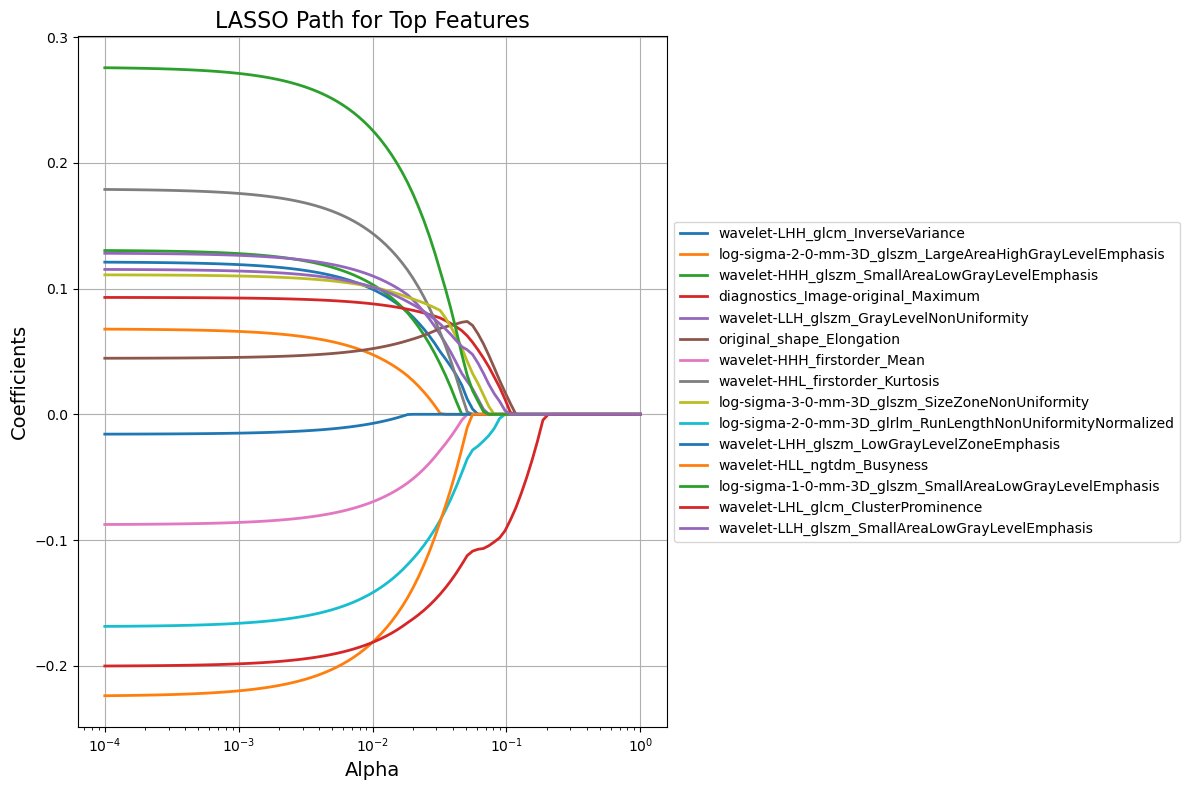

In [36]:
# Compute path for the top features
alphas_lasso, coefs_lasso, _ = lasso_path(X_scaled[:, top_features_idx], y, alphas=np.logspace(-4, 0, 100))

# Plot the path for top features
plt.figure(figsize=(12, 8))
for i in range(coefs_lasso.shape[0]):
    plt.plot(alphas_lasso, coefs_lasso[i, :], label=top_features[i], linewidth=2)

plt.xlabel('Alpha', fontsize=14)
plt.ylabel('Coefficients', fontsize=14)
plt.title('LASSO Path for Top Features', fontsize=16)
plt.xscale('log')
plt.grid(True)

# Place legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.tight_layout()
plt.show()

The LASSO path plot shows the coefficients of the top radiomic features as the regularization parameter alpha increases. Each line represents a feature, and the x-axis (log scale) shows alpha values, while the y-axis shows coefficient values. As alpha increases (left to right), stronger regularization is applied, shrinking coefficients towards zero. Features with non-zero coefficients at higher alpha values are more significant. The plot identifies robust features like wavelet-LHH_glcm_InverseVariance and log-sigma-2-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis that remain important despite increased regularization, indicating their predictive power in distinguishing between high and low Ki-67 groups.

In [39]:
# Performing statistical analysis on the results (t-test)

# Get list of feature columns 
feature_columns = [col for col in combined_df.columns if col not in ['ID', 'Group', 'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Spacing']]

# Create a DataFrame for results
results = pd.DataFrame(columns=['Feature', 'P-Value'])

# T-test for each feature
for feature in feature_columns:
    high_group_values = combined_df[combined_df['Group'] == 'High'][feature]
    low_group_values = combined_df[combined_df['Group'] == 'Low'][feature]
    
    # Perform t-test
    t_stat, p_val = ttest_ind(high_group_values, low_group_values, nan_policy='omit')
    
    # Append results using loc
    results.loc[len(results)] = {'Feature': feature, 'P-Value': p_val}

# Display features with p-value < 0.05
significant_features = results[results['P-Value'] < 0.05]
print("Significant Features (P-Value < 0.05):")
display(significant_features)

Significant Features (P-Value < 0.05):


,Feature,P-Value
13,original_shape_Elongation,0.035536
46,original_glcm_ClusterProminence,0.023276
47,original_glcm_ClusterShade,0.024548
53,original_glcm_DifferenceVariance,0.017083
86,original_glszm_GrayLevelNonUniformityNormalized,0.024775
...,...,...
1076,wavelet-LLL_glcm_DifferenceVariance,0.006399
1109,wavelet-LLL_glszm_GrayLevelNonUniformityNormal...,0.013970
1110,wavelet-LLL_glszm_GrayLevelVariance,0.017196
1117,wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,0.037702


Again, The fact that shape_elongation and GLCM_ClusterShade and GLSZM_GrayLevelNonUniformityNormal coming up as significant is a promising indicator that this analysis is in fact similar to that carried out by Ahmed et al. However there are still some missing radiomic features here that are significant in the study such as shape_flatness.

I will carry out a LASSO regression to see which features it determines as significant predictors specifically out of the significant features of the t-test.

In [40]:
# Define features and target variable
X = combined_df.drop(columns=['Group'])
y = combined_df['Group'].apply(lambda x: 1 if x == 'High' else 0)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform LASSO regression with 100000 iterations
lasso = LassoCV(cv=10, random_state=42, max_iter=100000)
lasso.fit(X_train_scaled, y_train)

# Get the coefficients and features
coefficients = pd.Series(lasso.coef_, index=X.columns)

# Filter out non-zero coefficients
significant_features = coefficients[coefficients != 0]
print("Significant features identified by LASSO regression:")
print(significant_features)

# Evaluate model performance
print(f"Training score: {lasso.score(X_train_scaled, y_train)}")
print(f"Test score: {lasso.score(X_test_scaled, y_test)}")

Significant features identified by LASSO regression:
original_shape_Elongation                                    0.046561
log-sigma-3-0-mm-3D_glszm_SizeZoneNonUniformityNormalized    0.001514
wavelet-LHL_firstorder_Skewness                              0.021305
wavelet-LHH_firstorder_Mean                                 -0.028691
wavelet-LHH_firstorder_Skewness                             -0.015119
wavelet-HHH_glcm_ClusterShade                                0.062216
wavelet-HHH_ngtdm_Strength                                  -0.016594
ID                                                           0.077069
dtype: float64
Training score: 0.42711766960049236
Test score: 0.09933634834230043
